<a href="https://colab.research.google.com/github/sohan-raj/Chatbot/blob/main/langGraph_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install langchain-community
!pip install arxiv
!pip install wikipedia
!pip install pydantic
!pip install langchain
!pip install langchain-core
!pip install langchain-groq
!pip install langgraph


In [31]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper

In [32]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_result = 2 , doc_content_chars = 500)
arxiv = ArxivQueryRun(api_wrapper = api_wrapper_arxiv,description = "Query arxiv paper")

In [33]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\n\n

In [34]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_result = 2 , doc_content_chars = 500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)

In [35]:
from google.colab import userdata
import os
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

In [36]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [37]:
tools = [arxiv,wiki,tavily]

In [38]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = "qwen-qwq-32B")

In [39]:
llm_with_tools = llm.bind_tools(tools = tools)

In [40]:
llm_with_tools.invoke("What is recent news on AI")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mbyv', 'function': {'arguments': '{"query": "recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 354, 'total_tokens': 541, 'completion_time': 0.467322118, 'prompt_time': 0.046083875, 'queue_time': 2.1557995620000003, 'total_time': 0.513405993}, 'model_name': 'qwen-qwq-32B', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4750d8be-721e-4b71-a6c4-4125083f9474-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent AI news'}, 'id': 'call_mbyv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 354, 'output_tokens': 187, 'total_tokens': 541})

## langGraph Workflow

In [41]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages #Reducer in LangGraph

In [42]:
from langchain_core.messages import AnyMessage

In [43]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [44]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [56]:
def tool_calling_llm(state:State):
  return {'messages':[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")


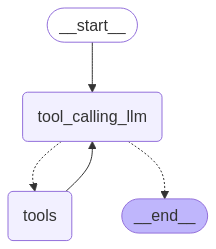

In [57]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
from langchain_core.messages import HumanMessage
messages = graph.invoke({"messages":HumanMessage(content = "please tell me about recent research paper on quantum computing and impact of the recent advancement in quantum computing")})

for message in messages['messages']:
  message.pretty_print()

================================ Human Message =================================

Hi, My name is Sohan and please tell me about recent research paper on quantum computing and impact of the recent advancement in quantum computing
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_v1hf)
 Call ID: call_v1hf
  Args:
    query: recent research on quantum computing
  tavily_search_results_json (call_f86d)
 Call ID: call_f86d
  Args:
    query: impact of recent advancements in quantum computing
================================= Tool Message =================================
Name: arxiv

Published: 2021-09-24
Title: Quantum Computation Using Action Variables
Authors: Yong Zhang, Konglong Wu
Summary: Recently, Lloyd and Montangero have made a brief research proposal on
universal quantum computation in integrable systems. The main idea is to encode
qubits into quantum action variables and build up quantum gates by the method
of resonant con